# Metric learning for image similarity search

001에 대해 샘플링 99개
df_photoReview_001_selected

## Overview

Metric learning aims to train models that can embed inputs into a high-dimensional space
such that "similar" inputs, as defined by the training scheme, are located close to each
other. These models once trained can produce embeddings for downstream systems where such
similarity is useful; examples include as a ranking signal for search or as a form of
pretrained embedding model for another supervised problem.

For a more detailed overview of metric learning see:

* [What is metric learning?](http://contrib.scikit-learn.org/metric-learn/introduction.html)
* ["Using crossentropy for metric learning" tutorial](https://www.youtube.com/watch?v=Jb4Ewl5RzkI)

Metric learning provides training data not as explicit `(X, y)` pairs but instead uses
multiple instances that are related in the way we want to express similarity. In our
example we will use instances of the same class to represent similarity; a single
training instance will not be one image, but a pair of images of the same class. When
referring to the images in this pair we'll use the common metric learning names of the
`anchor` (a randomly chosen image) and the `positive` (another randomly chosen image of
the same class).

To facilitate this we need to build a form of lookup that maps from classes to the
instances of that class. When generating data for training we will sample from this
lookup.

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_photoReview_001_selected = pd.read_csv("/content/drive/Othercomputers/내 노트북/001001/df_photoReview_001_selected_metric.csv", dtype=object)

In [4]:
df_photoReview_001_selected 

,anchor,positive,negative,goodsId,reviewIdPhoto,reviewDatePhoto,major_category,mid_category,sample_path_local,review_path_local,sample_path_drive,review_path_drive,anchor_numpy,positive_numpy
0,https://image.msscdn.net/images/goods_img/2022...,https://image.msscdn.net/data/estimate/2479585...,0,2479585,35753611,며칠전으로 표시된 리뷰,001,001001,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,/content/drive/Othercomputers/내 노트북/001001/anc...,/content/drive/Othercomputers/내 노트북/001001/pos...,[[[1. 1. 1.]\n [1. 1. 1.]\n [1. 1. 1.]\n .....,[[[0.5921569 0.5764706 0.53333336]\n [0.592...
1,https://image.msscdn.net/images/goods_img/2021...,https://image.msscdn.net/data/estimate/1876392...,0,1876392,34475524,2022.11.04,001,001001,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,/content/drive/Othercomputers/내 노트북/001001/anc...,/content/drive/Othercomputers/내 노트북/001001/pos...,[[[1. 1. 1.]\n [1. 1. 1.]\n [1. 1. 1.]\n .....,[[[0.7882353 0.8235294 0.84313726]\n [0.792...
2,https://image.msscdn.net/images/goods_img/2021...,https://image.msscdn.net/data/estimate/1753093...,0,1753093,30327286,2022.09.05,001,001001,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,/content/drive/Othercomputers/내 노트북/001001/anc...,/content/drive/Othercomputers/내 노트북/001001/pos...,[[[1. 1. 1.]\n [1. 1. 1.]\n [1. 1. 1.]\n .....,[[[0.52156866 0.5411765 0.61960787]\n [0.517...
3,https://image.msscdn.net/images/goods_img/2019...,https://image.msscdn.net/data/estimate/1010593...,0,1010593,33640215,2022.10.15,001,001001,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,/content/drive/Othercomputers/내 노트북/001001/anc...,/content/drive/Othercomputers/내 노트북/001001/pos...,[[[0.87058824 0.87058824 0.87058824]\n [0.870...,[[[0.6431373 0.62352943 0.54901963]\n [0.639...
4,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1382658...,0,1382658,25902871,2022.03.05,001,001001,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,/content/drive/Othercomputers/내 노트북/001001/anc...,/content/drive/Othercomputers/내 노트북/001001/pos...,[[[0.8235294 0.8235294 0.83137256]\n [0.819...,[[[0.41568628 0.34901962 0.30980393]\n [0.431...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,https://image.msscdn.net/images/goods_img/2021...,https://image.msscdn.net/data/estimate/2015372...,0,2015372,35906819,며칠전으로 표시된 리뷰,001,001011,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,/content/drive/Othercomputers/내 노트북/001001/anc...,/content/drive/Othercomputers/내 노트북/001001/pos...,[[[0.84705883 0.8901961 0.9137255 ]\n [0.847...,[[[0.94509804 0.8980392 0.79607844]\n [0.949...
894,https://image.msscdn.net/images/goods_img/2020...,https://image.msscdn.net/data/estimate/1466673...,0,1466673,18676906,2021.07.31,001,001011,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,/content/drive/Othercomputers/내 노트북/001001/anc...,/content/drive/Othercomputers/내 노트북/001001/pos...,[[[1. 1. 1.]\n [1. 1. 1.]\n [1. 1. 1.]\n .....,[[[0.99607843 1. 0.96862745]\n [0.996...
895,https://image.msscdn.net/images/goods_img/2022...,https://image.msscdn.net/data/estimate/2373147...,0,2373147,31043234,2022.08.03,001,001011,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,/content/drive/Othercomputers/내 노트북/001001/anc...,/content/drive/Othercomputers/내 노트북/001001/pos...,[[[0.9764706 0.9764706 0.96862745]\n [0.976...,[[[0.13333334 0.10588235 0.1764706 ]\n [0.141...
896,https://image.msscdn.net/images/goods_img/2022...,https://image.msscdn.net/data/estimate/2614114...,0,2614114,29495579,2022.06.18,001,001011,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric_le...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\metric

In [5]:
anchor_numpy_list = []

for i, row in df_photoReview_001_selected.iterrows():
    img = Image.open(row["sample_path_drive"])
    img_2 = img.crop((0,0,500,500))
    npd = np.array(img_2).astype("float32") /255.0
    try:
        npd = np.reshape(npd, (500,500,3))
    except:
        print(i)
    
#     file = os.path.join(base_dir_a,i)
#     elm = myPreprocess_image_fin(file)
    anchor_numpy_list.append(npd)
    
positive_numpy_list = []
for i, row in df_photoReview_001_selected.iterrows():
    img = Image.open(row["review_path_drive"])
    img_2 = img.crop((0,0,500,500))
    npd = np.array(img_2).astype("float32") /255.0
    try:
        npd = np.reshape(npd, (500,500,3))
    except:
        print(i)
    
#     file = os.path.join(base_dir_p,i)
#     elm = myPreprocess_image_fin(file)
    positive_numpy_list.append(npd)
    

df_photoReview_001_selected["anchor_numpy"] = anchor_numpy_list 
df_photoReview_001_selected["positive_numpy"] = positive_numpy_list

In [6]:
height_width = 500

In [7]:
class_idx_dict = {'001001': 0,'001002': 1,'001003': 2,'001004': 3,'001005': 4,'001006': 5,'001008': 6,'001010': 7,'001011': 8}

In [8]:
df_photoReview_001_selected.loc[10, 'anchor_numpy']

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [9]:
num_classes = 9


class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        for i, row in df_photoReview_001_selected.groupby("mid_category").get_group("001001").sample(99).iterrows():
            class_idx = class_idx_dict['001001']
            x[0, class_idx] = row['anchor_numpy']
            x[1, class_idx] = row['positive_numpy']
        for i, row in df_photoReview_001_selected.groupby("mid_category").get_group("001002").sample(99).iterrows():
            class_idx = class_idx_dict['001002']
            x[0, class_idx] = row['anchor_numpy']
            x[1, class_idx] = row['positive_numpy']
        for i, row in df_photoReview_001_selected.groupby("mid_category").get_group("001003").sample(99).iterrows():
            class_idx = class_idx_dict['001003']
            x[0, class_idx] = row['anchor_numpy']
            x[1, class_idx] = row['positive_numpy']
        for i, row in df_photoReview_001_selected.groupby("mid_category").get_group("001004").sample(99).iterrows():
            class_idx = class_idx_dict['001004']
            x[0, class_idx] = row['anchor_numpy']
            x[1, class_idx] = row['positive_numpy']
        for i, row in df_photoReview_001_selected.groupby("mid_category").get_group("001005").sample(99).iterrows():
            class_idx = class_idx_dict['001005']
            x[0, class_idx] = row['anchor_numpy']
            x[1, class_idx] = row['positive_numpy']
        for i, row in df_photoReview_001_selected.groupby("mid_category").get_group("001006").sample(99).iterrows():
            class_idx = class_idx_dict['001006']
            x[0, class_idx] = row['anchor_numpy']
            x[1, class_idx] = row['positive_numpy']
        for i, row in df_photoReview_001_selected.groupby("mid_category").get_group("001008").sample(99).iterrows():
            class_idx = class_idx_dict['001008']
            x[0, class_idx] = row['anchor_numpy']
            x[1, class_idx] = row['positive_numpy']
        for i, row in df_photoReview_001_selected.groupby("mid_category").get_group("001010").sample(99).iterrows():
            class_idx = class_idx_dict['001010']
            x[0, class_idx] = row['anchor_numpy']
            x[1, class_idx] = row['positive_numpy']
        for i, row in df_photoReview_001_selected.groupby("mid_category").get_group("001011").sample(99).iterrows():
            class_idx = class_idx_dict['001011']
            x[0, class_idx] = row['anchor_numpy']
            x[1, class_idx] = row['positive_numpy']
        
        return x

## Embedding model

We define a custom model with a `train_step` that first embeds both anchors and positives
and then uses their pairwise dot products as logits for a softmax.

In [10]:

class EmbeddingModel(keras.Model):
    def train_step(self, data):
        # Note: Workaround for open issue, to be removed.
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            # Run both anchors and positives through model.
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)

            # Calculate cosine similarity between anchors and positives. As they have
            # been normalised this is just the pair wise dot products.
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            # Since we intend to use these as logits we scale them by a temperature.
            # This value would normally be chosen as a hyper parameter.
            temperature = 0.2
            similarities /= temperature

            # We use these similarities as logits for a softmax. The labels for
            # this call are just the sequence [0, 1, 2, ..., num_classes] since we
            # want the main diagonal values, which correspond to the anchor/positive
            # pairs, to be high. This loss will move embeddings for the
            # anchor/positive pairs together and move all other pairs apart.
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

        # Calculate gradients and apply via optimizer.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}


Next we describe the architecture that maps from an image to an embedding. This model
simply consists of a sequence of 2d convolutions followed by global pooling with a final
linear projection to an embedding space. As is common in metric learning we normalise the
embeddings so that we can use simple dot products to measure similarity. For simplicity
this model is intentionally small.

In [11]:
inputs = layers.Input(shape=(height_width, height_width, 3))
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)

Finally we run the training. On a Google Colab GPU instance this takes about a minute.

Epoch 1/30
99/99 [==============================] - 78s 682ms/step - loss: 2.1881
Epoch 2/30
99/99 [==============================] - 68s 689ms/step - loss: 2.1867
Epoch 3/30
99/99 [==============================] - 69s 693ms/step - loss: 2.1935
Epoch 4/30
99/99 [==============================] - 68s 690ms/step - loss: 2.0939
Epoch 5/30
99/99 [==============================] - 68s 688ms/step - loss: 1.9803
Epoch 6/30
99/99 [==============================] - 69s 700ms/step - loss: 1.9534
Epoch 7/30
99/99 [==============================] - 71s 712ms/step - loss: 1.8909
Epoch 8/30
99/99 [==============================] - 70s 705ms/step - loss: 1.9065
Epoch 9/30
99/99 [==============================] - 70s 709ms/step - loss: 1.8403
Epoch 10/30
99/99 [==============================] - 69s 699ms/step - loss: 1.8551
Epoch 11/30
99/99 [==============================] - 69s 695ms/step - loss: 1.8979
Epoch 12/30
99/99 [==============================] - 69s 697ms/step - loss: 1.8286
Epoch 13/30
9

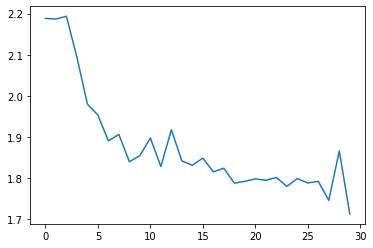

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

history = model.fit(AnchorPositivePairs(num_batchs=99), epochs=30)

plt.plot(history.history["loss"])
plt.show()

## Testing

We can review the quality of this model by applying it to the test set and considering
near neighbours in the embedding space.

First we embed the test set and calculate all near neighbours. Recall that since the
embeddings are unit length we can calculate cosine similarity via dot products.

In [13]:
df_photoReview_001_selected_test = pd.read_csv("/content/drive/Othercomputers/내 노트북/001001_test/df_photoReview_001_selected_test.csv", dtype=object)

In [14]:
anchor_numpy_list = []

for i, row in df_photoReview_001_selected_test.iterrows():
    img = Image.open(row["sample_path_drive"])
    img_2 = img.crop((0,0,500,500))
    npd = np.array(img_2).astype("float32") /255.0
    try:
        npd = np.reshape(npd, (500,500,3))
    except:
        print(i)
    
#     file = os.path.join(base_dir_a,i)
#     elm = myPreprocess_image_fin(file)
    anchor_numpy_list.append(npd)
    
positive_numpy_list = []
for i, row in df_photoReview_001_selected_test.iterrows():
    img = Image.open(row["review_path_drive"])
    img_2 = img.crop((0,0,500,500))
    npd = np.array(img_2).astype("float32") /255.0
    try:
        npd = np.reshape(npd, (500,500,3))
    except:
        print(i)
    
#     file = os.path.join(base_dir_p,i)
#     elm = myPreprocess_image_fin(file)
    positive_numpy_list.append(npd)
    

df_photoReview_001_selected_test["anchor_numpy"] = anchor_numpy_list 
df_photoReview_001_selected_test["positive_numpy"] = positive_numpy_list

In [25]:
x_test_1 = np.empty((num_classes, height_width, height_width, 3), dtype=np.float32)
x_test_2 = np.empty((num_classes, height_width, height_width, 3), dtype=np.float32)
for i, row in df_photoReview_001_selected_test.groupby("mid_category").get_group("001001").sample(10).iterrows():
    class_idx = class_idx_dict['001001']
    x_test_1[class_idx] = row['anchor_numpy']
    x_test_2[class_idx] = row['positive_numpy']
for i, row in df_photoReview_001_selected_test.groupby("mid_category").get_group("001002").sample(10).iterrows():
    class_idx = class_idx_dict['001002']
    x_test_1[class_idx] = row['anchor_numpy']
    x_test_2[class_idx] = row['positive_numpy']
for i, row in df_photoReview_001_selected_test.groupby("mid_category").get_group("001003").sample(10).iterrows():
    class_idx = class_idx_dict['001003']
    x_test_1[class_idx] = row['anchor_numpy']
    x_test_2[class_idx] = row['positive_numpy']
for i, row in df_photoReview_001_selected_test.groupby("mid_category").get_group("001004").sample(10).iterrows():
    class_idx = class_idx_dict['001004']
    x_test_1[class_idx] = row['anchor_numpy']
    x_test_2[class_idx] = row['positive_numpy']
for i, row in df_photoReview_001_selected_test.groupby("mid_category").get_group("001005").sample(10).iterrows():
    class_idx = class_idx_dict['001005']
    x_test_1[class_idx] = row['anchor_numpy']
    x_test_2[class_idx] = row['positive_numpy']
for i, row in df_photoReview_001_selected_test.groupby("mid_category").get_group("001006").sample(10).iterrows():
    class_idx = class_idx_dict['001006']
    x_test_1[class_idx] = row['anchor_numpy']
    x_test_2[class_idx] = row['positive_numpy']
for i, row in df_photoReview_001_selected_test.groupby("mid_category").get_group("001008").sample(10).iterrows():
    class_idx = class_idx_dict['001008']
    x_test_1[class_idx] = row['anchor_numpy']
    x_test_2[class_idx] = row['positive_numpy']
for i, row in df_photoReview_001_selected_test.groupby("mid_category").get_group("001010").sample(10).iterrows():
    class_idx = class_idx_dict['001010']
    x_test_1[class_idx] = row['anchor_numpy']
    x_test_2[class_idx] = row['positive_numpy']
for i, row in df_photoReview_001_selected_test.groupby("mid_category").get_group("001011").sample(10).iterrows():
    class_idx = class_idx_dict['001011']
    x_test_1[class_idx] = row['anchor_numpy']
    x_test_2[class_idx] = row['positive_numpy']

In [29]:
near_neighbours_per_example = 9

embeddings = model.predict(x_test_1)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

1/1 [==============================] - 0s 44ms/step


In [30]:
near_neighbours

array([[7, 1, 8, 6, 2, 5, 4, 3, 0],
       [4, 3, 0, 2, 5, 6, 8, 7, 1],
       [7, 1, 8, 6, 0, 3, 4, 5, 2],
       [7, 1, 8, 6, 5, 2, 0, 4, 3],
       [7, 1, 8, 6, 5, 0, 2, 3, 4],
       [7, 1, 8, 6, 0, 3, 4, 2, 5],
       [0, 1, 3, 4, 7, 8, 5, 2, 6],
       [3, 4, 0, 2, 5, 6, 1, 8, 7],
       [3, 4, 0, 2, 5, 6, 1, 7, 8]])

In [31]:
near_neighbours_per_example = 9

embeddings = model.predict(x_test_2)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

1/1 [==============================] - 0s 40ms/step


In [32]:
near_neighbours

array([[7, 1, 8, 6, 5, 4, 2, 3, 0],
       [4, 5, 2, 0, 3, 6, 7, 8, 1],
       [1, 8, 7, 6, 0, 3, 5, 4, 2],
       [7, 1, 8, 6, 5, 4, 2, 0, 3],
       [8, 1, 7, 6, 0, 3, 5, 2, 4],
       [8, 1, 7, 0, 3, 6, 4, 2, 5],
       [0, 1, 8, 3, 7, 4, 2, 5, 6],
       [4, 0, 5, 3, 2, 6, 8, 1, 7],
       [4, 5, 2, 0, 3, 6, 7, 1, 8]])

As a visual check of these embeddings we can build a collage of the near neighbours for 5
random examples. The first column of the image below is a randomly selected image, the
following 10 columns show the nearest neighbours in order of similarity.

We can also get a quantified view of the performance by considering the correctness of
near neighbours in terms of a confusion matrix.

Let us sample 10 examples from each of the 10 classes and consider their near neighbours
as a form of prediction; that is, does the example and its near neighbours share the same
class?

We observe that each animal class does generally well, and is confused the most with the
other animal classes. The vehicle classes follow the same pattern.

In [ ]:
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = ["001001","001002","001003","001004","001005","001006","001008","001010","001011"]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()